In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/DNN_Mgard")

In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import copy
from sklearn import preprocessing

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import colormaps

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import seaborn as sns
sns.set_style("whitegrid")

current_palette = sns.color_palette("deep")
# current_palette = sns.color_palette("Paired")

fontsize=20

In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import *

import copy
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import random
random.seed(10)

In [19]:
gpu = torch.cuda.is_available()

In [4]:
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"{func}:{elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [5]:
Threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10,
             0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,
             0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30,
             0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]

In [6]:
# # correlation
# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = ["%.e" % number for number in traintest_data.reqerr.values/traintest_data.drange.values]
# Relerr = ["1e-01", "1e-03", "1e-05"]

# dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log",
#           "baryon_density", "dark_matter_density", "temperature", "velocity_x",
#           "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",]

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(len(dnames)):

#     dname = dnames[i]
#     ax1 = fig1.add_subplot(3, 4, i+1)

#     for j in np.arange(len(Relerr)):
#         relerr = Relerr[j]
#         data = traintest_data[(traintest_data.dname.str.contains(dname)) & (traintest_data.relerr == relerr)]

#         drange = data.drange.values
#         c0 = data.c0.values
#         c1 = data.c1.values
#         c2 = data.c2.values

#         # ax1.plot(np.arange(len(c0)), np.array(c1)*np.array(c2))

#         # ax1.plot(np.arange(len(c0)), c0, "-", label="{}-c0".format(dname))
#         # ax1.plot(np.arange(len(c1)), c1, "-.", label="{}-c1".format(dname), color=current_palette[j])
#         ax1.plot(np.arange(len(c2)), c2, "--", label="{}-c2".format(dname), color=current_palette[j])

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(0, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="left")
#     ax1.text(0, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="left")

In [7]:
# traintest_data

In [8]:
def preprocess(traintest_data, num_lvl, split_ratio=0.2, target="c2", shuffle=True):

    df_data_feature = traintest_data[["reqerr", "threshold"]].copy()
    df_data_target  = traintest_data[[target]].copy()

    # if num_lvl == 2:
    #     df_data_target  = traintest_data[["c0", "c1"]].copy()
    # elif num_lvl == 3:
    #     df_data_target  = traintest_data[["c0", "c1", "c2"]].copy()
    # elif num_lvl == 4:
    #     df_data_target  = traintest_data[["c0", "c1", "c2", "c3"]].copy()

    data_feature  = np.array(df_data_feature.astype("float32"))
    data_target   = np.array(df_data_target.astype("float32"))

    X_train, X_test, Y_train, Y_test = train_test_split(data_feature, data_target, test_size=split_ratio,
                                                        shuffle=shuffle, random_state=233)

    # normalizer = preprocessing.Normalizer()
    # normalized_train_X = normalizer.fit_transform(X_train)
    # normalized_test_X  = normalizer.transform(X_test)

    # return normalized_train_X, normalized_test_X, Y_train, Y_test
    return X_train, X_test, Y_train, Y_test

In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.model1 = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(8, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 8),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(8, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(2, 1),
        )

        self.model2 = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 2),
        )

        self.model3 = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 3),
        )

        self.model4 = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 4),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, prediction, target):
        loss = torch.nn.L1Loss(reduction='sum')(prediction, target)
        return loss

In [11]:
@timer
def train(X_train, Y_train, num_lvl, num_epoch, learning_rate):
    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))

    net = MLP().model1
    # if num_lvl == 2:
    #     net = MLP().model2
    # elif num_lvl == 3:
    #     net = MLP().model3
    # elif num_lvl == 4:
    #     net = MLP().model4

    if gpu:
        net = net.to("cuda")

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_func = MyLoss()

    BATCH_SIZE = 32
    EPOCH = num_epoch

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True, num_workers=2,)

    # start training
    print("Training: model{}".format(num_lvl))
    for epoch in range(EPOCH):
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            if gpu:
                b_x = b_x.to("cuda")
                b_y = b_y.to("cuda")
            prediction = net(b_x)     # input x and predict based on x
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

        if epoch % 100 == 0:
            if gpu:
                print(loss.to("cpu").detach().numpy())
            else:
                print(loss.detach().numpy())
    return net

In [12]:
def inference(feature, net, target):
    if gpu:
        feature = Variable(torch.from_numpy(feature)).to("cuda")
        target = Variable(torch.from_numpy(target)).to("cuda")
        prediction = net(feature)
        return target.to("cpu").detach().numpy(), prediction.to("cpu").detach().numpy()
    else:
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        prediction = net(feature)
        return target.detach().numpy(), prediction.detach().numpy()

In [13]:
def validate_var(net, x_test, y_test):
    return inference(x_test, net, y_test)

In [14]:
dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log", #
          "baryon_density", "dark_matter_density", "temperature", "velocity_x",
          "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",] #

traintest_data = pd.read_csv("traintest_3d_convex.csv")
traintest_data["relerr"] = ["%.e" % number for number in traintest_data.reqerr.values/traintest_data.drange.values]

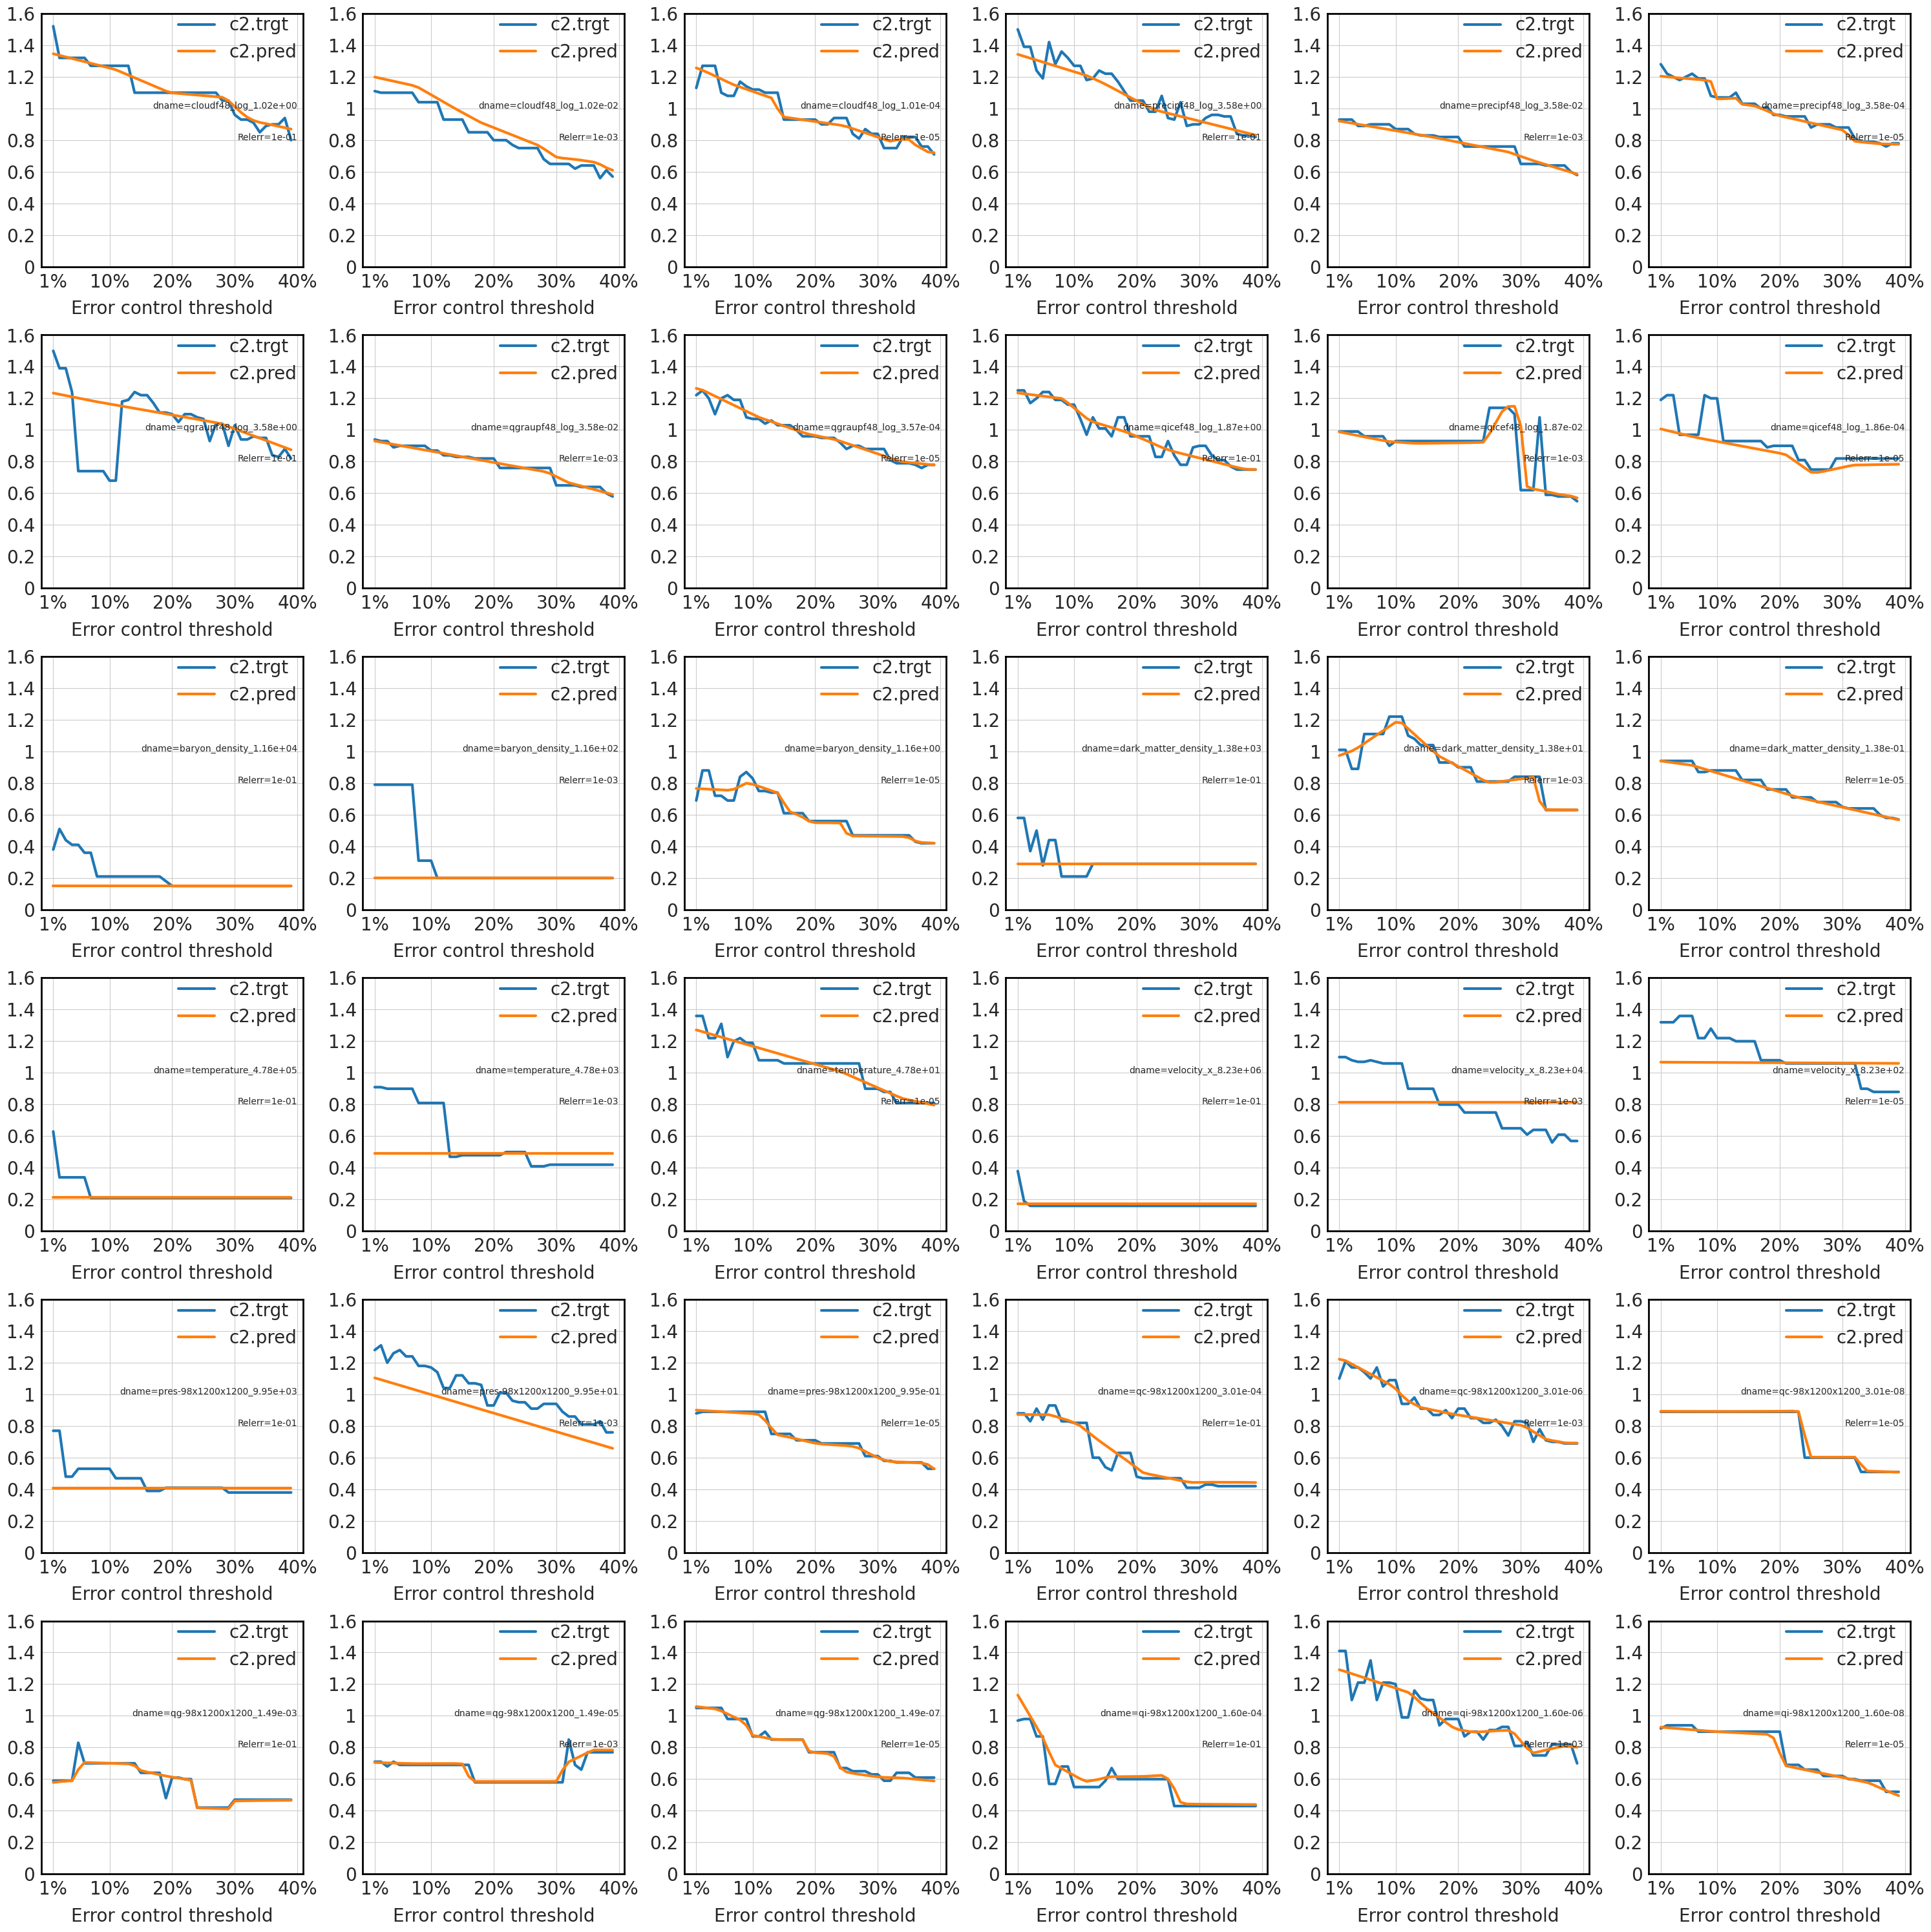

In [21]:
Relerr = ["1e-01", "1e-03", "1e-05"]

plt.rcParams["figure.figsize"] = [6*5, 6*5]
fig1 = plt.figure()
for i in np.arange(0, len(dnames)): #
    dname = dnames[i]

    for j in np.arange(3):
        relerr = Relerr[j]
        data = traintest_data[(traintest_data.dname.str.contains(dname)) & (traintest_data.relerr == relerr)]

        if True:
        # if dname in ["temperature", "velocity_x"]:
            # X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.1, target="c2", shuffle=True)
            # net = train(X_train, Y_train, num_lvl=3, num_epoch=800, learning_rate=0.01)
            # torch.save(net.state_dict(), os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c2")))
            if gpu:
                net = MLP().model1.to("cuda")
                net.load_state_dict(torch.load(os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c2"))))
            else:
                net = MLP().model1
                net.load_state_dict(torch.load(os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c2")), map_location=torch.device('cpu')))

            X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.01, target="c2", shuffle=False)
            target, prediction = validate_var(net, X_train, Y_train)

            ax1 = fig1.add_subplot(6, 6, i*len(Relerr)+j+1)
            ax1.plot(np.arange(len(target)),     target,     lw=3, label="{}.trgt".format("c2"))
            ax1.plot(np.arange(len(prediction)), prediction, lw=3, label="{}.pred".format("c2"))

            ax1.set_xticks([0, 9, 19, 29, 39])
            ax1.set_xticklabels(["1%", "10%", "20%", "30%", "40%"], fontsize=fontsize)
            ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
            ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
            ax1.text(39, 1, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
            ax1.text(39, .8, "Relerr={}".format(relerr), horizontalalignment="right")

            ax1.set_xlabel('Error control threshold', labelpad=10, fontsize=fontsize)
            ax1.set_ylabel('', labelpad=5, fontsize=fontsize)

            ax1.spines["bottom"].set_color("black")
            ax1.spines["top"].set_color("black")
            ax1.spines["right"].set_color("black")
            ax1.spines["left"].set_color("black")

            ax1.legend(frameon=False, fancybox=False, ncol=1, bbox_to_anchor=(.75, .9), loc='center', fontsize=20, borderpad=.1, labelspacing=.5)

fig1.tight_layout()

Training: model3
3.9544468
0.030867457
0.12275335
0.06451979
0.09086484
0.05497688
0.05555561
0.062859
<function train at 0x7bcd799e63b0>:72.1936 seconds
Training: model3
1.028023
0.06003055
0.04465279
0.081594855
0.03848687
0.033224225
0.016092777
0.107489884
<function train at 0x7bcd799e63b0>:73.8683 seconds
Training: model3
0.9267937
0.06843011
0.15929054
0.1131669
0.09989184
0.3038196
0.114395484
0.1990799
<function train at 0x7bcd799e63b0>:77.0552 seconds
Training: model3
0.782604
0.30107355
0.29599002
0.2476935
0.21256353
0.21585113
0.07057515
0.15233798
<function train at 0x7bcd799e63b0>:83.7160 seconds
Training: model3
0.93044704
0.07635352
0.010556877
0.051454544
0.023614138
0.014027983
0.04238552
0.011510402
<function train at 0x7bcd799e63b0>:89.1084 seconds
Training: model3
0.19155805
0.062891886
0.06541416
0.07433094
0.07376319
0.0725413
0.049322426
0.04025981
<function train at 0x7bcd799e63b0>:93.7897 seconds
Training: model3
1.7134273
0.51554644
0.569658
0.21508585
0.4478

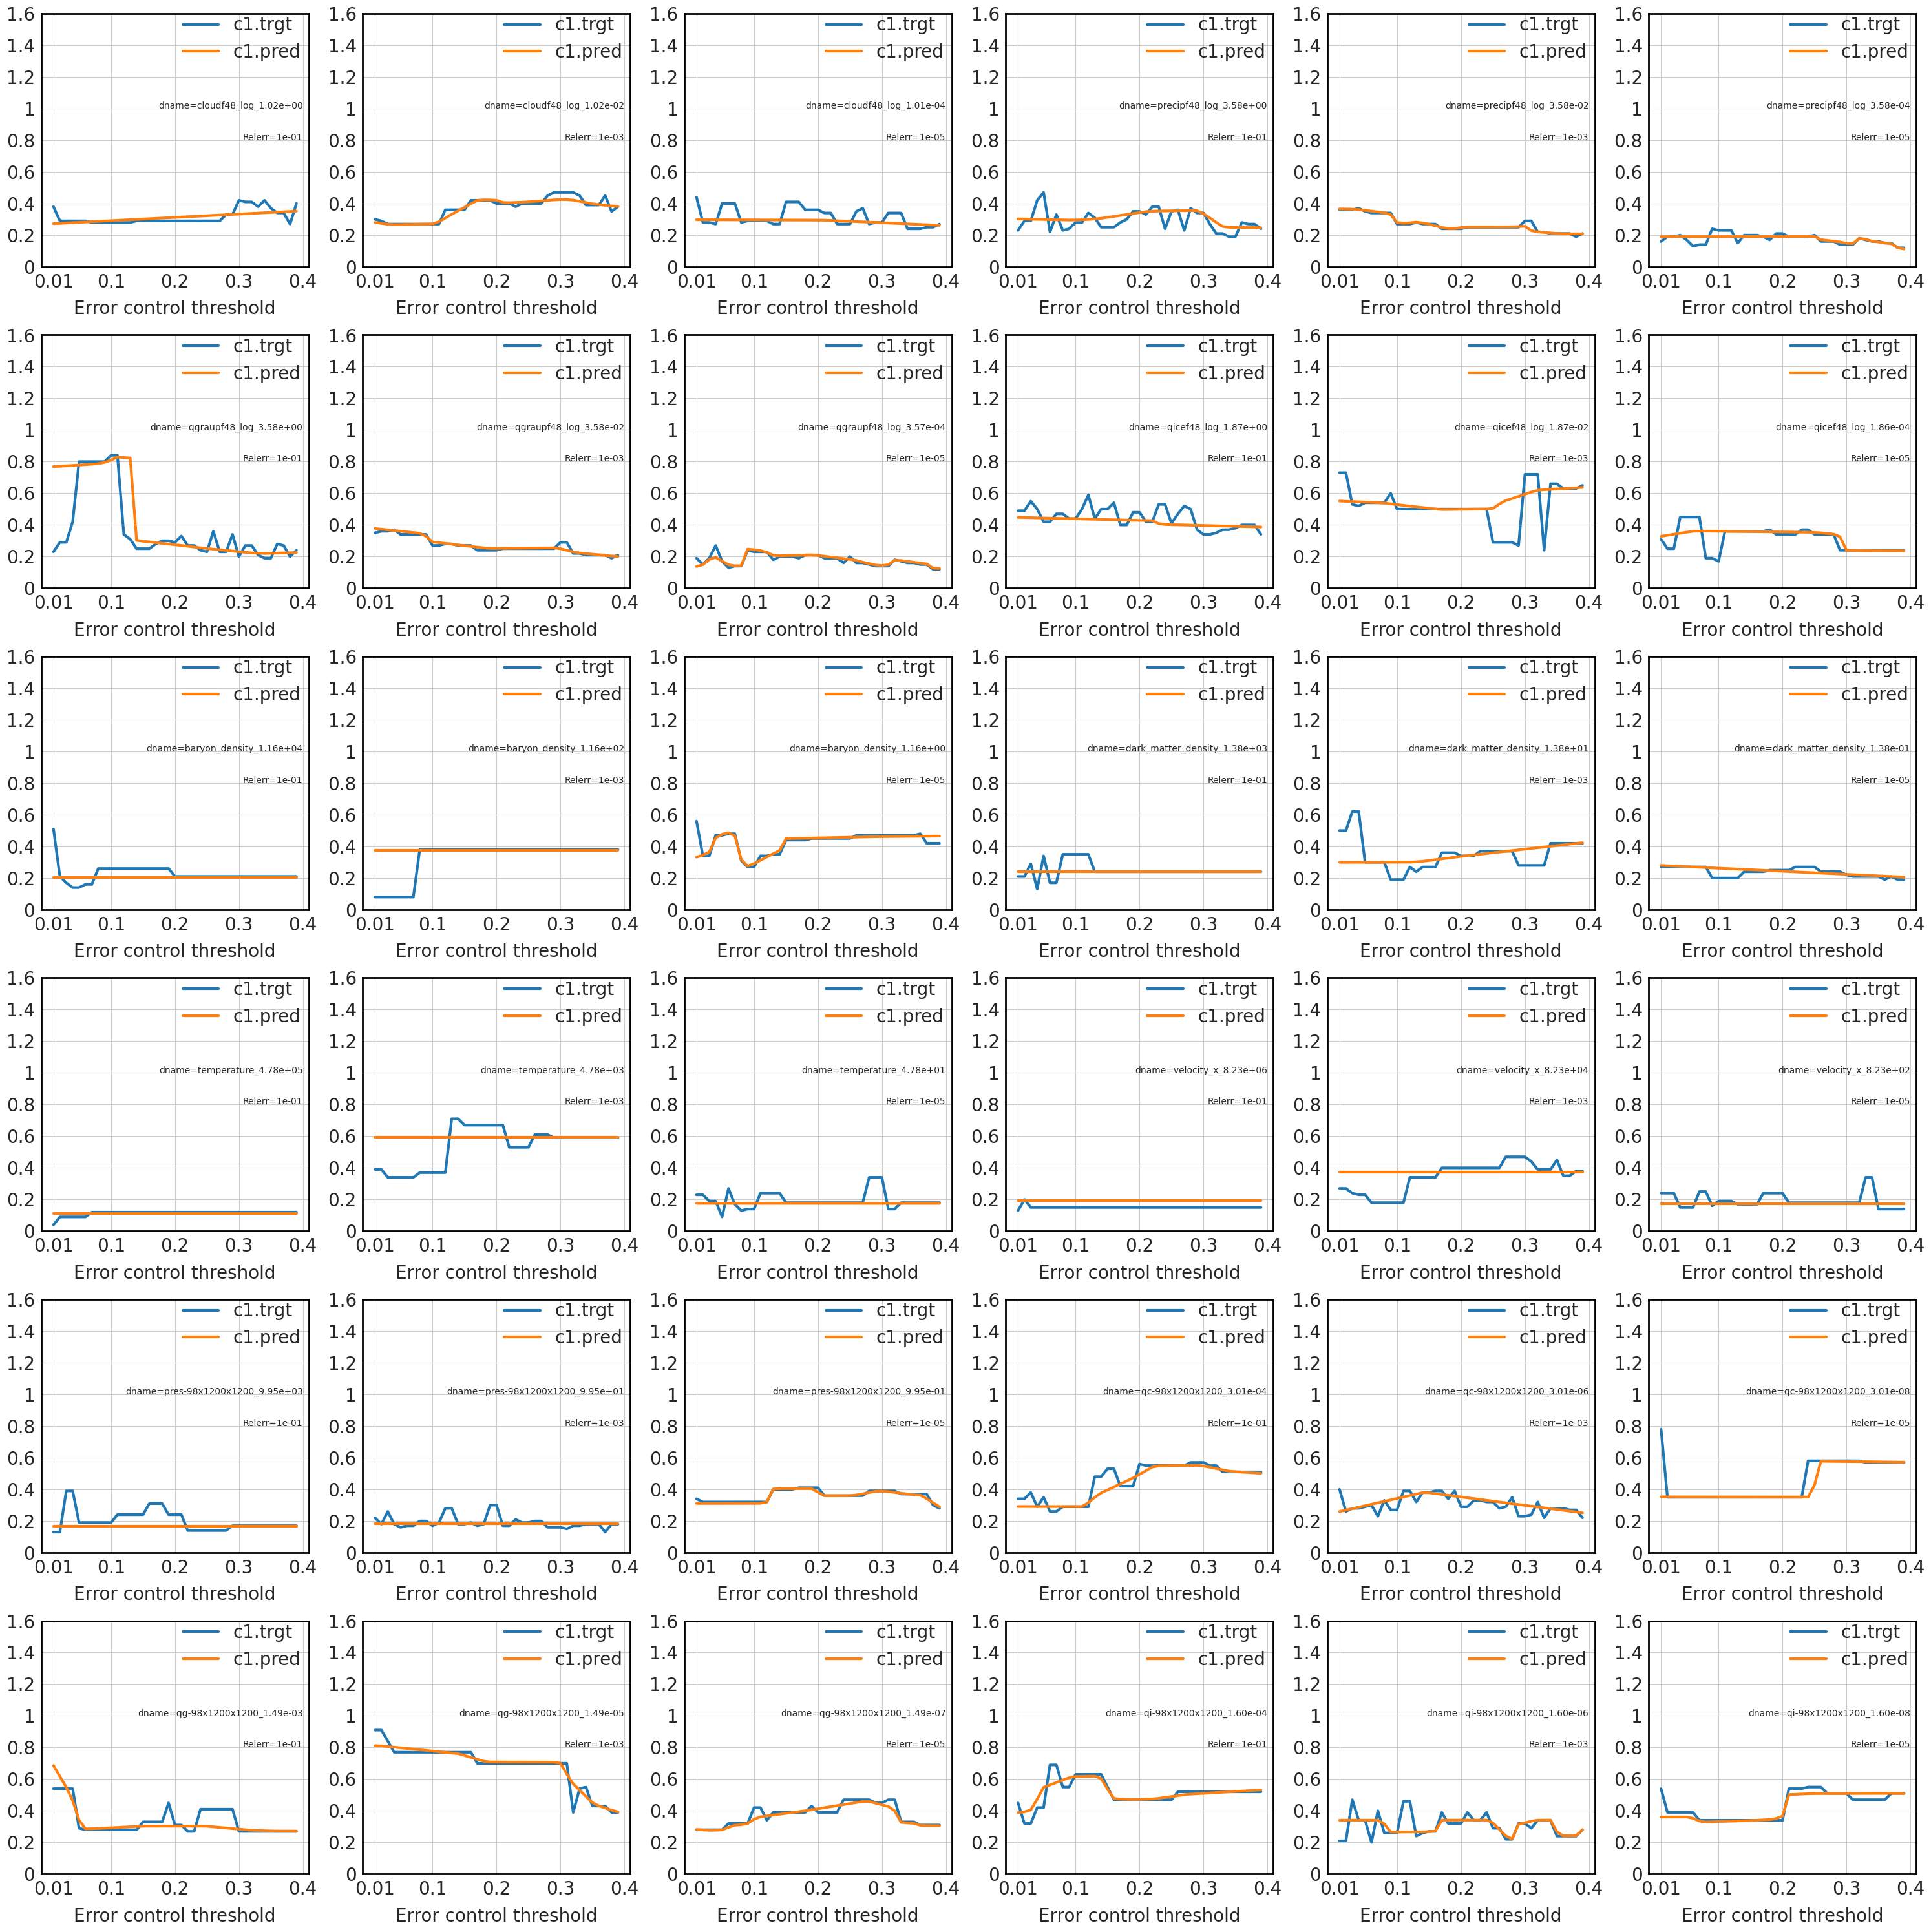

In [23]:
Relerr = ["1e-01", "1e-03", "1e-05"]

plt.rcParams["figure.figsize"] = [6*5, 6*5]
fig1 = plt.figure()
for i in np.arange(0, len(dnames)): #
    dname = dnames[i]

    for j in np.arange(3):
        relerr = Relerr[j]
        data = traintest_data[(traintest_data.dname.str.contains(dname)) & (traintest_data.relerr == relerr)]

        if True:
        # if dname in ["temperature", "velocity_x"]:
            X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.1, target="c1", shuffle=True)
            net = train(X_train, Y_train, num_lvl=3, num_epoch=800, learning_rate=0.01)
            torch.save(net.state_dict(), os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c1")))

            # if gpu:
            #     net = MLP().model1.to("cuda")
            #     net.load_state_dict(torch.load(os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c1"))))
            # else:
            #     net = MLP().model1
            #     net.load_state_dict(torch.load(os.path.join("./", "net_{}_{}_{}.pt".format(dname, relerr, "c1")), map_location=torch.device('cpu')))

            X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.01, target="c1", shuffle=False)
            target, prediction = validate_var(net, X_train, Y_train)

            ax1 = fig1.add_subplot(6, 6, i*len(Relerr)+j+1)
            ax1.plot(np.arange(len(target)),     target,     lw=3, label="{}.trgt".format("c1"))
            ax1.plot(np.arange(len(prediction)), prediction, lw=3, label="{}.pred".format("c1"))

            ax1.set_xticks([0, 9, 19, 29, 39])
            ax1.set_xticklabels([0.01, 0.1, 0.2, 0.3, 0.4], fontsize=fontsize)
            ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
            ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
            ax1.text(39, 1, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
            ax1.text(39, .8, "Relerr={}".format(relerr), horizontalalignment="right")

            ax1.set_xlabel('Error control threshold', labelpad=10, fontsize=fontsize)
            ax1.set_ylabel('', labelpad=5, fontsize=fontsize)

            ax1.spines["bottom"].set_color("black")
            ax1.spines["top"].set_color("black")
            ax1.spines["right"].set_color("black")
            ax1.spines["left"].set_color("black")

            ax1.legend(frameon=False, fancybox=False, ncol=1, bbox_to_anchor=(.75, .9), loc='center', fontsize=20, borderpad=.1, labelspacing=.5)

fig1.tight_layout()
fig1.show()

In [ ]:
# if __name__ == "__main__":
#     # the main starts here
#     traintest_data = pd.read_csv("traintest_3d_convex.csv")
#     # traintest_data = traintest_data[traintest_data['dname'].str.contains('cloudf48_log')]
#     X_train, X_test, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.1, shuffle=False)

#     print(np.shape(X_train), np.shape(Y_train), np.shape(X_test), np.shape(Y_test))
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=3200, learning_rate=0.0001)

In [ ]:
# Relerr = ["1e-01", "1e-03", "1e-05"]

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(9, 12): # len(dnames)
#     dname = dnames[i]

#     for j in np.arange(3):
#         relerr = Relerr[j]
#         # relerr = Relerr[1]
#         data = traintest_data[(traintest_data.dname.str.contains(dname)) & (traintest_data.relerr == relerr)]

#         X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.1, shuffle=False)
#         net = train(X_train, Y_train, num_lvl=3, num_epoch=400, learning_rate=0.01)

#         X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.9, shuffle=False)
#         target, prediction = validate_var(net, X_test, Y_test)

#         # drange = data.drange.values
#         # c0 = data.c0.values
#         # c1 = data.c1.values
#         # c2 = data.c2.values

#         ax1 = fig1.add_subplot(3, 4, (i-9)*3+j+1)
#         # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#         # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#         # ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))
#         ax1.plot(np.arange(len(target)), target, label="{}-c2".format(dname))
#         ax1.plot(np.arange(len(prediction)), prediction, label="{}-c2".format(dname))

#         ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#         ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#         ax1.text(35, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#         ax1.text(35, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")